# <center>Audio Emotion Recognition</center>
## <center>Part 3 - Baseline model</center>
#### <center> 24th August 2019 </center> 
#####  <center> Eu Jin Lok </center> 

## Introduction 
Continuing where we left off in [Part 1](https://www.kaggle.com/ejlok1/audio-emotion-recognition-part-1-explore-data) and [Part 2](https://www.kaggle.com/ejlok1/audio-emotion-recognition-part-2-feature-extra), here we'll build a baseline model for an emotion classifier. When I say baseline, I mean its the simplest most parsimonious model I can think of. And view points will vary from one data scientist to another, but essentially its a model __NOT__ meant to achieve full accuracy potential. It's just to qucikly test the framework and setup the blueprint for how we go about creating a workable emotion classifier, cause at the moment, we don't know what works and what doesn't. This is a long notebook so this is the agenda below: 

1. [Data preparation and processing](#data)
    * [Data preparation](#preparation)
    * [Data processing](#processing)
2. [Modelling](#modelling)
3. [Model serialisation](#serialise)
4. [Model validation](#validation)
5. [Final thoughts](#final)

Upvote this notebook if you like, and be sure to check out the other parts which are now available:
* [Part 4 | Apply to new audio data](https://www.kaggle.com/ejlok1/audio-emotion-part-4-apply-to-new-audio-data)
* [Part 5 | Data augmentation](https://www.kaggle.com/ejlok1/audio-emotion-part-5-data-augmentation)

Most importantly, I want to thank the 4 authors for their excellent dataset, without it, writing this notebook could not have been possible. The original source of the dataset links are below:

- [TESS](https://tspace.library.utoronto.ca/handle/1807/24487)
- [CREMA-D](https://github.com/CheyneyComputerScience/CREMA-D)
- [SAVEE](http://kahlan.eps.surrey.ac.uk/savee/Database.html)
- [RAVDESS](https://zenodo.org/record/1188976#.XYP8CSgzaUk)
- [RAVDESS_Kaggle](https://www.kaggle.com/uwrfkaggler/ravdess-emotional-speech-audio)

In [1]:
# Importing required libraries 
# Keras
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Other  
import matplotlib.pyplot as plt
import librosa
import librosa.display
import json
import numpy as np
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import os
import pickle
import IPython.display as ipd  # To play sound in the notebook

<a id="data"></a>
## 1. Data preparation and processing
We saw in [Part 1](https://www.kaggle.com/ejlok1/audio-emotion-recognition-part-1-explore-data) and [Part 2](https://www.kaggle.com/ejlok1/audio-emotion-recognition-part-2-feature-extra) the way we process the audio file into data and the MFCC features we extracted. We're going to do the same thing here except we process the entirity of the audio files. First up we need the reference file that contains the path to the raw audio files for training.

<a id="preparation"></a>
### Data preparation
Lets pick up the meta-data file which we save in [part 1]("https://www.kaggle.com/ejlok1/audio-emotion-recognition-part-1-explore-data"), we're going to need it here to run a loop over it to read all the audio files spread across the 4 directories. 

In [3]:
# lets pick up the meta-data that we got from our first part of the Kernel
ref = pd.read_csv("Data_path.csv")
ref.head()

,labels,source,path
0,male_sad,SAVEE,input/ALL/JK_sa01.wav
1,male_sad,SAVEE,input/ALL/JK_sa15.wav
2,male_neutral,SAVEE,input/ALL/DC_n13.wav
3,male_surprise,SAVEE,input/ALL/DC_su09.wav
4,male_neutral,SAVEE,input/ALL/DC_n07.wav


So we've already seen the shape of an MFCC output for each file, and it's a 2D matrix of the number of bands by time. In order to optimise space and memory, we're going to read each audio file, extract its mean across all MFCC bands by time, and  just keep the extracted features, dropping the entire audio file data. 

In [4]:
# Note this takes a couple of minutes (~10 mins) as we're iterating over 4 datasets 
df = pd.DataFrame(columns=['feature'])

# loop feature extraction over the entire dataset
counter=0
for index,path in enumerate(ref.path):
    X, sample_rate = librosa.load(path
                                  , res_type='kaiser_fast'
                                  ,duration=2.5
                                  ,sr=44100
                                  ,offset=0.5
                                 )
    sample_rate = np.array(sample_rate)
    
    # mean as the feature. Could do min and max etc as well. 
    mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                        sr=sample_rate, 
                                        n_mfcc=13),
                    axis=0)
    df.loc[counter] = [mfccs]
    counter=counter+1   

# Check a few records to make sure its processed successfully
print(len(df))
df.head()

12162


,feature
0,"[-8.812322, -12.111704, -22.594236, -21.481213..."
1,"[-8.84645, -13.126471, -24.391258, -23.972637,..."
2,"[-2.0016851, -2.2841876, -8.079337, -7.4936037..."
3,"[-3.6122117, -4.3207064, -7.5397215, -8.864785..."
4,"[-0.8923286, -2.7065654, -9.859099, -8.692252,..."


<a id="processing"></a>
### Data processing

Like any good standard data science workflow, data processing is the most important step. Cause garbage in grabage out. So lets start munging the data into a workable format and pad out any issues we find. 

In [5]:
# Now extract the mean bands to its own feature columns
df = pd.concat([ref,pd.DataFrame(df['feature'].values.tolist())],axis=1)
df[:5]

,labels,source,path,0,1,2,3,4,5,6,...,206,207,208,209,210,211,212,213,214,215
0,male_sad,SAVEE,input/ALL/JK_sa01.wav,-8.812322,-12.111704,-22.594236,-21.481213,-20.949923,-20.414585,-20.267546,...,-8.499665,-10.080903,-12.700766,-17.040064,-20.240370,-23.302591,-24.621035,-23.829395,-14.862103,-9.119078
1,male_sad,SAVEE,input/ALL/JK_sa15.wav,-8.846450,-13.126471,-24.391258,-23.972637,-23.494141,-24.208843,-25.631187,...,-8.738687,-8.822191,-8.977811,-9.998902,-15.777987,-22.670012,-23.585888,-24.138813,-17.324165,-9.067061
2,male_neutral,SAVEE,input/ALL/DC_n13.wav,-2.001685,-2.284188,-8.079337,-7.493604,-7.611508,-5.591492,-4.388683,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,male_surprise,SAVEE,input/ALL/DC_su09.wav,-3.612212,-4.320706,-7.539721,-8.864785,-8.661814,-8.826547,-9.143904,...,-25.902903,-25.006645,-24.709747,-25.516712,-26.941380,-25.354641,-25.213074,-27.607460,-16.149429,-8.528479
4,male_neutral,SAVEE,input/ALL/DC_n07.wav,-0.892329,-2.706565,-9.859099,-8.692252,-8.685309,-8.844451,-8.032233,...,-11.438392,-11.691319,-11.480921,-10.730119,-9.891496,-9.329518,-8.907435,-8.881424,-8.354049,-5.121763


In [6]:
# replace NA with 0
df=df.fillna(0)
print(df.shape)
df[:5]

(12162, 219)


,labels,source,path,0,1,2,3,4,5,6,...,206,207,208,209,210,211,212,213,214,215
0,male_sad,SAVEE,input/ALL/JK_sa01.wav,-8.812322,-12.111704,-22.594236,-21.481213,-20.949923,-20.414585,-20.267546,...,-8.499665,-10.080903,-12.700766,-17.040064,-20.240370,-23.302591,-24.621035,-23.829395,-14.862103,-9.119078
1,male_sad,SAVEE,input/ALL/JK_sa15.wav,-8.846450,-13.126471,-24.391258,-23.972637,-23.494141,-24.208843,-25.631187,...,-8.738687,-8.822191,-8.977811,-9.998902,-15.777987,-22.670012,-23.585888,-24.138813,-17.324165,-9.067061
2,male_neutral,SAVEE,input/ALL/DC_n13.wav,-2.001685,-2.284188,-8.079337,-7.493604,-7.611508,-5.591492,-4.388683,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,male_surprise,SAVEE,input/ALL/DC_su09.wav,-3.612212,-4.320706,-7.539721,-8.864785,-8.661814,-8.826547,-9.143904,...,-25.902903,-25.006645,-24.709747,-25.516712,-26.941380,-25.354641,-25.213074,-27.607460,-16.149429,-8.528479
4,male_neutral,SAVEE,input/ALL/DC_n07.wav,-0.892329,-2.706565,-9.859099,-8.692252,-8.685309,-8.844451,-8.032233,...,-11.438392,-11.691319,-11.480921,-10.730119,-9.891496,-9.329518,-8.907435,-8.881424,-8.354049,-5.121763


Now that looks alot better. Next step we will split the data into 2 parts, one for training and one for validation. This ensures we measure the model's performance at its true accuracy. 

In [7]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(df.drop(['path','labels','source'],axis=1)
                                                    , df.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )

# Lets see how the data present itself before normalisation 
X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
4950,-17.142696,-17.249537,-18.365582,-18.948351,-17.365459,-16.711090,-17.699482,-18.021383,-17.897398,-15.878503,...,-22.865425,-21.614164,-19.724932,-18.845335,-19.363422,-20.137630,-22.65514,-24.578310,-24.039165,-23.209587
3860,-18.354397,-20.836168,-22.571033,-22.155430,-20.623474,-17.927940,-15.832610,-18.623466,-21.543407,-24.989613,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
9761,-4.823565,-6.056048,-9.580621,-12.012063,-9.959867,-11.912548,-13.994515,-13.555813,-14.022305,-15.118246,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
7620,-7.031146,-4.253551,-4.534490,-5.836689,-5.248197,-6.456452,-8.122451,-9.154640,-8.647813,-8.178625,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
11586,-22.565975,-21.767015,-20.529488,-20.669310,-21.171085,-18.573399,-18.412350,-16.178038,-14.222460,-15.122540,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
7914,-20.082027,-18.982424,-17.009443,-16.944057,-19.334974,-19.527683,-21.974346,-20.144060,-17.954927,-19.302570,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
9513,-20.103537,-18.625866,-16.116108,-16.929594,-18.197668,-18.149664,-19.240425,-18.361637,-16.917982,-16.639193,...,-17.848896,-19.357054,-17.748692,-19.136808,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
5835,-21.078182,-18.671947,-17.676802,-18.009502,-18.218781,-18.676929,-16.592762,-17.796528,-17.992470,-17.824917,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
5389,-22.707445,-20.160748,-18.926155,-19.429979,-19.278114,-18.125767,-18.068565,-19.879320,-20.896755,-19.176098,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
11222,-20.008287,-17.640305,-19.188612,-18.435749,-17.538836,-17.817177,-17.898476,-20.555359,-18.578117,-15.957151,...,-18.031603,-18.101122,-19.630695,-20.707493,-20.239124,-18.337662,-15.54331,-17.478794,-17.017057,-19.112486


Now because we are mixing up a few different data sources, it would be wise to normalise the data. This is proven to improve the accuracy and speed up the training process. Prior to the discovery of this solution in the embrionic years of neural network, the problem used to be know as "exploding gradients". 

In [8]:
# Lts do data normalization 
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Check the dataset now 
X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
4950,0.373270,0.352227,0.438396,0.389021,0.498961,0.542144,0.461018,0.432419,0.435712,0.581127,...,-0.874217,-0.805570,-0.685764,-0.625542,-0.671389,-0.713683,-0.856419,-0.980170,-0.965941,-0.910889
3860,0.286191,0.088576,0.127417,0.152359,0.258929,0.452538,0.598172,0.388228,0.168150,-0.086836,...,0.539838,0.525971,0.525370,0.526296,0.511449,0.511353,0.512023,0.500333,0.493808,0.487405
9761,1.258580,1.175052,1.088016,0.900874,1.044563,0.895499,0.733212,0.760179,0.720084,0.636864,...,0.539838,0.525971,0.525370,0.526296,0.511449,0.511353,0.512023,0.500333,0.493808,0.487405
7620,1.099933,1.307553,1.461161,1.356577,1.391693,1.297275,1.164616,1.083213,1.114490,1.145629,...,0.539838,0.525971,0.525370,0.526296,0.511449,0.511353,0.512023,0.500333,0.493808,0.487405
11586,-0.016472,0.020150,0.278383,0.262025,0.218584,0.405008,0.408646,0.567715,0.705396,0.636549,...,0.539838,0.525971,0.525370,0.526296,0.511449,0.511353,0.512023,0.500333,0.493808,0.487405
7914,0.162036,0.224843,0.538679,0.536925,0.353858,0.334736,0.146956,0.276621,0.431490,0.330098,...,0.539838,0.525971,0.525370,0.526296,0.511449,0.511353,0.512023,0.500333,0.493808,0.487405
9513,0.160490,0.251054,0.604738,0.537992,0.437648,0.436211,0.347810,0.407445,0.507586,0.525359,...,-0.563982,-0.666520,-0.564420,-0.643357,0.511449,0.511353,0.512023,0.500333,0.493808,0.487405
5835,0.090447,0.247666,0.489330,0.458302,0.436093,0.397384,0.542326,0.448923,0.428735,0.438429,...,0.539838,0.525971,0.525370,0.526296,0.511449,0.511353,0.512023,0.500333,0.493808,0.487405
5389,-0.026639,0.138226,0.396944,0.353480,0.358047,0.437970,0.433903,0.296052,0.215605,0.339370,...,0.539838,0.525971,0.525370,0.526296,0.511449,0.511353,0.512023,0.500333,0.493808,0.487405
11222,0.167335,0.323502,0.377536,0.426848,0.486187,0.460694,0.446399,0.246432,0.385757,0.575361,...,-0.575281,-0.589149,-0.679978,-0.739358,-0.724882,-0.604185,-0.426842,-0.552522,-0.539532,-0.664053


For the sake of documentation, I'll just mention here that there's another method for normalisation but it hasn't worked out well, at least not when I implemented it. So I swapped in for something more simple, which is what i've implemented above. Perhaps someone else could give it a try below

```python
max_data = np.max(X_train)
min_data = np.min(X_train)
X_train = (X_train-min_data)/(max_data-min_data+1e-6)
X_train =  X_train-0.5

max_data = np.max(X_test)
min_data = np.min(X_test)
X_test = (X_test-min_data)/(max_data-min_data+1e-6)
X_test =  X_test-0.5

X_train[150:160]
```

Next part we'll need to convert the data format to a numpy array, because we are using keras. Initially I had plans to use XGboost or LightGBM for this task. But since I've potential plans to move to a 2D CNN, it may make sense to continue on the Deep Learning path way and implement a ID CNN.

In [9]:
# Lets few preparation steps to get it into the correct format for Keras 
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# one hot encode the target 
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))

print(X_train.shape)
print(lb.classes_)
#print(y_train[0:10])
#print(y_test[0:10])

# Pickel the lb object for future use 
filename = 'labels'
outfile = open(filename,'wb')
pickle.dump(lb,outfile)
outfile.close()

(9121, 216)
['female_angry' 'female_disgust' 'female_fear' 'female_happy'
 'female_neutral' 'female_sad' 'female_surprise' 'male_angry'
 'male_disgust' 'male_fear' 'male_happy' 'male_neutral' 'male_sad'
 'male_surprise']


-------------------
Now because we are using a CNN, we need to specify the 3rd dimension, which for us is 1. Its 1 because we're doing a 1D CNN and not a 2D CNN. If we use the MFCC data in its entirity, we could feed that through as the input data, thus making the network a 2D CNN.  

In [10]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(9121, 216, 1)

<a id="modelling"></a>
## 2. Modelling
The architecture of the model below is based on a few sources that I've seen before such as Kaggle and Stackoverflow. I'm unable to find the source but safe to say this particular format works quite well and is fast, although I've used GPU. 

In [13]:
# New model
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(14)) # Target class number
model.add(Activation('softmax'))
# opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
# opt = keras.optimizers.Adam(lr=0.0001)
opt = keras.optimizers.RMSprop(lr=0.00001)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_16 (Conv1D)          (None, 216, 256)          2304      
                                                                 
 activation_18 (Activation)  (None, 216, 256)          0         
                                                                 
 conv1d_17 (Conv1D)          (None, 216, 256)          524544    
                                                                 
 batch_normalization_4 (Bat  (None, 216, 256)          1024      
 chNormalization)                                                
                                                                 
 activation_19 (Activation)  (None, 216, 256)          0         
                                                                 
 dropout_4 (Dropout)         (None, 216, 256)          0         
                                                      

In [14]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(X_train, y_train, batch_size=16, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
571/571 [==============================] - 31s 53ms/step - loss: 2.2083 - accuracy: 0.2165 - val_loss: 2.3672 - val_accuracy: 0.1394
Epoch 2/100
571/571 [==============================] - 31s 54ms/step - loss: 2.0141 - accuracy: 0.2812 - val_loss: 2.1604 - val_accuracy: 0.2532
Epoch 3/100
571/571 [==============================] - 31s 55ms/step - loss: 1.9185 - accuracy: 0.3167 - val_loss: 2.0331 - val_accuracy: 0.2677
Epoch 4/100
571/571 [==============================] - 30s 53ms/step - loss: 1.8360 - accuracy: 0.3507 - val_loss: 1.9133 - val_accuracy: 0.3035
Epoch 5/100
571/571 [==============================] - 30s 52ms/step - loss: 1.7849 - accuracy: 0.3657 - val_loss: 1.8540 - val_accuracy: 0.3288
Epoch 6/100
571/571 [==============================] - 30s 53ms/step - loss: 1.7601 - accuracy: 0.3802 - val_loss: 1.8979 - val_accuracy: 0.3239
Epoch 7/100
571/571 [==============================] - 30s 53ms/step - loss: 1.7162 - accuracy: 0.3924 - val_loss: 1.9163 - val_ac

571/571 [==============================] - 32s 56ms/step - loss: 1.4716 - accuracy: 0.4851 - val_loss: 1.8867 - val_accuracy: 0.3604
Epoch 58/100
571/571 [==============================] - 32s 56ms/step - loss: 1.4892 - accuracy: 0.4774 - val_loss: 1.9868 - val_accuracy: 0.3634
Epoch 59/100
571/571 [==============================] - 32s 56ms/step - loss: 1.4764 - accuracy: 0.4881 - val_loss: 1.8712 - val_accuracy: 0.3716
Epoch 60/100
571/571 [==============================] - 32s 55ms/step - loss: 1.4637 - accuracy: 0.4929 - val_loss: 1.9274 - val_accuracy: 0.3459
Epoch 61/100
571/571 [==============================] - 33s 57ms/step - loss: 1.4682 - accuracy: 0.4904 - val_loss: 1.8181 - val_accuracy: 0.3815
Epoch 62/100
571/571 [==============================] - 32s 55ms/step - loss: 1.4740 - accuracy: 0.4922 - val_loss: 2.0351 - val_accuracy: 0.3249
Epoch 63/100
571/571 [==============================] - 32s 56ms/step - loss: 1.4688 - accuracy: 0.4949 - val_loss: 1.8362 - val_accuracy

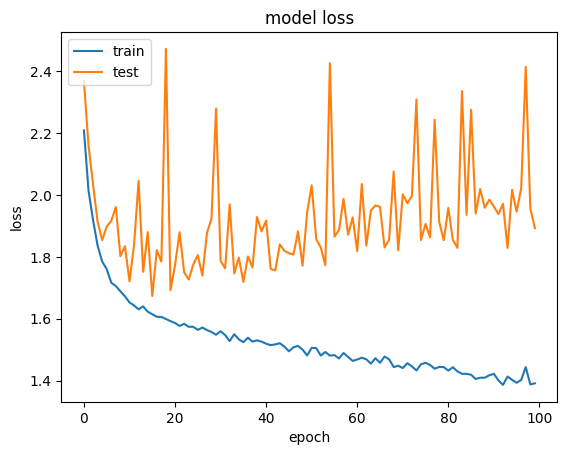

In [15]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

So we can see that the loss starts to plateau now at around 50 epochs. Regardless we'll keep it at 100 as the final model.

<a id="serialise"></a>
## 3. Model serialisation
So its time to serialise the model for re-usability. Serialisation and saving mean the same thing. We need to serialise the model architecture and the weights, thats all. 

In [16]:
# Save model and weights
model_name = 'Emotion_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("model_json.json", "w") as json_file:
    json_file.write(model_json)

Save model and weights at /Users/sayalidalvi/ashritha/AudioJournaling/model_training/saved_models/Emotion_Model.h5 


/Users/sayalidalvi/ashritha/Assignment3/venv/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<a id="validation"></a>
## 4. Model validation
Now predicting emotions on the test data. After serialising the model above, i'm going to just reload it into disk. Essentially to re-use the model without having to retrain by re-running the code, we just need to run this section of the code and apply the model to a new dataset. Since we used the same test set in the keras model, the result is essentially the same as the last epoch of 100 which is 43.80%

In [19]:
# loading json and model architecture 
json_file = open('model_json.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Model.h5")
print("Loaded model from disk")
 
# Keras optimiser
opt = keras.optimizers.RMSprop(lr=0.00001)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 35.15%


In [ ]:
preds = loaded_model.predict(X_test, 
                         batch_size=16, 
                         verbose=1)

preds=preds.argmax(axis=1)
preds

The prediction is in the form of numbers, we'll need to append the labels to it before we run the accuracy measure...

In [ ]:
# predictions 
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))
preds = pd.DataFrame({'predictedvalues': preds})

# Actual labels
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

# Lets combined both of them into a single dataframe
finaldf = actual.join(preds)
finaldf[170:180]

Lets write the predictions out into a file for re-use

In [ ]:
# Write out the predictions to disk
finaldf.to_csv('Predictions.csv', index=False)
finaldf.groupby('predictedvalues').count()

So, we've made our predictions, so how well have we done? We're going to use the most simplest form of accuracy measure which is absolute accuracy, which is really just the % of records where Actual = Predicted, over the total number of records predicted. We'll also produce the F1, recall and precision scores. 

The most common way to visualise this output is via a confusion matrix. I found an excellent heat map plot to visualise the accuracy of the confusion matrix [here](https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823) which i've borrowed for this notebook

In [ ]:
# the confusion matrix heat map plot
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Gender recode function
def gender(row):
    if row == 'female_disgust' or 'female_fear' or 'female_happy' or 'female_sad' or 'female_surprise' or 'female_neutral':
        return 'female'
    elif row == 'male_angry' or 'male_fear' or 'male_happy' or 'male_sad' or 'male_surprise' or 'male_neutral' or 'male_disgust':
        return 'male'


#### Emotion by gender accuracy  
So lets visualise how well we have done for the Emotion by Gender model

In [ ]:
# Get the predictions file 
finaldf = pd.read_csv("Predictions.csv")
classes = finaldf.actualvalues.unique()
classes.sort()    

# Confusion matrix 
c = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
print(accuracy_score(finaldf.actualvalues, finaldf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [ ]:
# Classification report 
classes = finaldf.actualvalues.unique()
classes.sort()    
print(classification_report(finaldf.actualvalues, finaldf.predictedvalues, target_names=classes))

Absolute accuracy for the gender by emotions is 43%. Whilst that may not seem high at first but remember, a random guess correct is 1 out of 14 which is 7%. So 43% is huge! The heat map plot below will do justice in illustrating how good the results is. And note we have only just scratched the surface

---------------
#### Gender accuracy result 
if you notice, that the gender classification is more accurate. So lets group them up and measure the accuracy again?

In [ ]:
modidf = finaldf
modidf['actualvalues'] = finaldf.actualvalues.replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

modidf['predictedvalues'] = finaldf.predictedvalues.replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

classes = modidf.actualvalues.unique()  
classes.sort() 

# Confusion matrix 
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [ ]:
# Classification report 
classes = modidf.actualvalues.unique()
classes.sort()    
print(classification_report(modidf.actualvalues, modidf.predictedvalues, target_names=classes))

With just gender we get a 80% accuracy. The model is especially precise in capturing female voices. However, male voices tends to be harder and it does make higher mistakes thinking its female. 

#### Emotion accuracy
We'll now ignore the gender part and just super group them into the 7 core emotions. Lets see what we get...

In [ ]:
modidf = pd.read_csv("Predictions.csv")
modidf['actualvalues'] = modidf.actualvalues.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

modidf['predictedvalues'] = modidf.predictedvalues.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

classes = modidf.actualvalues.unique() 
classes.sort() 

# Confusion matrix 
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [ ]:
# Classification report 
classes = modidf.actualvalues.unique()
classes.sort()    
print(classification_report(modidf.actualvalues, modidf.predictedvalues, target_names=classes))

50%, not too shabby indeed. The precision and recall for 'Surprise' and 'Angry' is pretty good in particular 

<a id="final"></a>
## 5. Final thoughts 
The gender seperation turns out to be a curcial implementation in order to accurately classify emotions. Upon closer inspection of the confusion matrix, it seems that female tends to express emotions in a more, obvious manner, for the lack of a better word. Whilst males tend to be very placid or subtle. This is probably why we see the error rate amongst males are really high. For example, male happy and angry gets mixed up quite often. 

In our next section we will be checking for generalisability of this initial baseline solution before  before implementing further enhancements, followed by an audio streamer that will give us the capability of predicting the emotions of a segment of the audio call.  

This section of the notebook borrowed heavily from this [repository](https://github.com/MITESHPUTHRANNEU/Speech-Emotion-Analyzer). The original author may have overstated the accuracy as I wasn't able to replicate the accuracy results but, by in large the approach is pretty sound and I've taken his work as a blueprint to setup my own here. 